In [1]:
import torchvision.transforms as transforms
import pandas as pd
from torchvision import datasets
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
import numpy as np
import torch


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Training on CPU.")


CUDA is available. Training on GPU.


## Data setup

In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transform, 
    download = False,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transform
)

In [4]:
trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=1)
testloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=1)

## Digit Recognizer Model

In [5]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Third convolutional layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Sequential(
            nn.Linear(3*3*128, 128),
            nn.ReLU(),
        )
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 3*3*128)  # Adjusted for the additional pooling
        x = self.fc1(self.dropout1(x))
        x = self.fc2(self.dropout2(x))
        return self.out(x)

## Training

In [6]:
model = DigitRecognizer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels.clone().detach().requires_grad_(False))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())
    print(f"Total Loss: {total_loss / len(trainloader)}")

torch.save(model.state_dict(), 'digit_recognizer_state_dict.pth')


Epoch 1: 100%|██████████| 938/938 [00:10<00:00, 85.95it/s, loss=0.0861]  


Total Loss: 0.21469536710725123


Epoch 2: 100%|██████████| 938/938 [00:10<00:00, 89.06it/s, loss=0.00796]  


Total Loss: 0.06530456071945284


Epoch 3: 100%|██████████| 938/938 [00:10<00:00, 86.56it/s, loss=0.000986] 


Total Loss: 0.04565724148121819


Epoch 4: 100%|██████████| 938/938 [00:10<00:00, 87.09it/s, loss=0.0465]   


Total Loss: 0.040187483837450494


Epoch 5: 100%|██████████| 938/938 [00:10<00:00, 87.53it/s, loss=0.00304]  


Total Loss: 0.030959140065401708


Epoch 6: 100%|██████████| 938/938 [00:10<00:00, 86.89it/s, loss=0.00751]  


Total Loss: 0.02628335120357745


Epoch 7: 100%|██████████| 938/938 [00:10<00:00, 88.01it/s, loss=0.00589]  


Total Loss: 0.024891117602545837


Epoch 8: 100%|██████████| 938/938 [00:10<00:00, 87.19it/s, loss=0.00764]  


Total Loss: 0.022211519873873767


Epoch 9: 100%|██████████| 938/938 [00:10<00:00, 87.40it/s, loss=0.00251]  


Total Loss: 0.018555678412713047


Epoch 10: 100%|██████████| 938/938 [00:11<00:00, 85.12it/s, loss=0.000351] 

Total Loss: 0.019541883190485977


## Test

In [7]:
test = pd.read_csv('test.csv')

In [8]:
model = DigitRecognizer()
model.load_state_dict(torch.load('digit_recognizer_state_dict.pth'))

<All keys matched successfully>

In [9]:
def plot_image_with_label(img, pred, ax):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(f'Predicted: {pred}')
    ax.axis('off')

## Output the csv file

In [10]:
with open('test.csv', 'r') as file, open('predictions.csv', 'w', newline='') as outfile:
    reader = csv.reader(file)
    writer = csv.writer(outfile)
    writer.writerow(['ImageID', 'Label'])  # Write header

    next(reader)
    image_id = 1
    for row in reader:
        image = np.array([float(pixel) for pixel in row], dtype=np.float32).reshape(28, 28, 1)  
        image = transform(image)

        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)

        writer.writerow([image_id, predicted.item()])
        image_id += 1

## Test Accuracy

In [15]:
def test():
    # Test the model
    model.eval()
    correct = 0  
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()  # Sum up correct predictions
            total += labels.size(0)  # Total number of labels
    
    accuracy = correct / total  # Calculate accuracy
    print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)

test()

Test Accuracy of the model on the 10000 test images: 0.9939


## Example Output

[2 0 9 0 3 7 0 3 0 3]


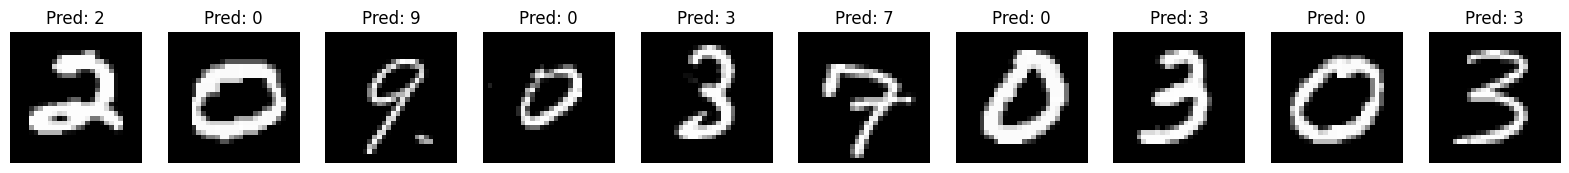

In [16]:
predictions = pd.read_csv('predictions.csv').to_numpy()
print(predictions[:10, 1])

# Open the CSV file and read lines
with open('test.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header

    images = []
    for i, row in enumerate(reader):
        if i >= 10:  # Only read the first 10 images
            break
        # Convert pixel values to a numpy array and reshape to 28x28
        image = np.array([float(pixel) for pixel in row], dtype=np.float32).reshape(28, 28)
        images.append(image)

# Plotting the images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  # Setup a figure with 10 subplots
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')  # Plot each image in grayscale
    ax.set_title(f'Pred: {predictions[i][1]}')
    ax.axis('off')  # Hide axes
plt.show()
